# Loop 4 Analysis: Understanding the Gap to Target

**Current best:** 70.675478
**Target:** 68.919154
**Gap:** 1.756 points (2.55%)

We've achieved the first real improvement (0.000624) but the gap is still huge. Let's analyze what's possible.

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
import matplotlib.pyplot as plt

# Tree geometry
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]
TREE_VERTICES = list(zip(TX, TY))

def parse_s_value(s):
    if isinstance(s, str) and s.startswith('s'):
        return float(s[1:])
    return float(s)

def create_tree_polygon(x, y, deg):
    poly = Polygon(TREE_VERTICES)
    poly = affinity.rotate(poly, deg, origin=(0, 0))
    poly = affinity.translate(poly, x, y)
    return poly

def get_bounding_box_side(polygons):
    if not polygons:
        return 0
    all_coords = []
    for poly in polygons:
        all_coords.extend(list(poly.exterior.coords))
    xs = [c[0] for c in all_coords]
    ys = [c[1] for c in all_coords]
    return max(max(xs) - min(xs), max(ys) - min(ys))

# Load current best solution
df = pd.read_csv('/home/code/experiments/005_long_optimization/submission.csv')
df['x_val'] = df['x'].apply(parse_s_value)
df['y_val'] = df['y'].apply(parse_s_value)
df['deg_val'] = df['deg'].apply(parse_s_value)

print(f"Loaded {len(df)} rows")

Loaded 20100 rows


In [2]:
# Calculate per-N scores and analyze where improvement is possible
results = []
for n in range(1, 201):
    prefix = f'{n:03d}_'
    group = df[df['id'].str.startswith(prefix)]
    polygons = [create_tree_polygon(row['x_val'], row['y_val'], row['deg_val']) for _, row in group.iterrows()]
    side = get_bounding_box_side(polygons)
    score = side**2 / n
    
    # Calculate tree area
    tree_area = Polygon(TREE_VERTICES).area
    total_tree_area = tree_area * n
    box_area = side**2
    efficiency = total_tree_area / box_area if box_area > 0 else 0
    
    results.append({
        'n': n,
        'side': side,
        'score': score,
        'efficiency': efficiency,
        'tree_area': total_tree_area,
        'box_area': box_area
    })

results_df = pd.DataFrame(results)
print(f"Total score: {results_df['score'].sum():.6f}")
print(f"Target: 68.919154")
print(f"Gap: {results_df['score'].sum() - 68.919154:.6f}")
print(f"\nTop 10 contributors to score:")
print(results_df.nlargest(10, 'score')[['n', 'side', 'score', 'efficiency']])

Total score: 70.675478
Target: 68.919154
Gap: 1.756324

Top 10 contributors to score:
     n      side     score  efficiency
0    1  0.813173  0.661250    0.371456
1    2  0.949504  0.450779    0.544890
2    3  1.142031  0.434745    0.564986
4    5  1.443692  0.416850    0.589241
3    4  1.290806  0.416545    0.589672
6    7  1.673104  0.399897    0.614221
5    6  1.548438  0.399610    0.614661
8    9  1.867280  0.387415    0.634010
7    8  1.755921  0.385407    0.637313
14  15  2.384962  0.379203    0.647740


In [3]:
# Analyze efficiency distribution
print("\nEfficiency statistics:")
print(results_df['efficiency'].describe())

# Find N values with lowest efficiency (most room for improvement)
print("\nLowest efficiency N values (most room for improvement):")
print(results_df.nsmallest(10, 'efficiency')[['n', 'side', 'score', 'efficiency']])

# Calculate theoretical best if all N had best efficiency
best_efficiency = results_df['efficiency'].max()
print(f"\nBest efficiency: {best_efficiency:.4f}")

# Theoretical minimum score if all N had best efficiency
theoretical_min = 0
for _, row in results_df.iterrows():
    # If we could pack at best efficiency, what would the side be?
    theoretical_side = np.sqrt(row['tree_area'] / best_efficiency)
    theoretical_score = theoretical_side**2 / row['n']
    theoretical_min += theoretical_score

print(f"Theoretical minimum score (if all N had best efficiency): {theoretical_min:.6f}")
print(f"Current score: {results_df['score'].sum():.6f}")
print(f"Potential improvement: {results_df['score'].sum() - theoretical_min:.6f}")


Efficiency statistics:
count    200.000000
mean       0.698092
std        0.039567
min        0.371456
25%        0.679789
50%        0.707787
75%        0.722354
max        0.744422
Name: efficiency, dtype: float64

Lowest efficiency N values (most room for improvement):
     n      side     score  efficiency
0    1  0.813173  0.661250    0.371456
1    2  0.949504  0.450779    0.544890
2    3  1.142031  0.434745    0.564986
4    5  1.443692  0.416850    0.589241
3    4  1.290806  0.416545    0.589672
6    7  1.673104  0.399897    0.614221
5    6  1.548438  0.399610    0.614661
8    9  1.867280  0.387415    0.634010
7    8  1.755921  0.385407    0.637313
14  15  2.384962  0.379203    0.647740

Best efficiency: 0.7444
Theoretical minimum score (if all N had best efficiency): 65.990795
Current score: 70.675478
Potential improvement: 4.684683


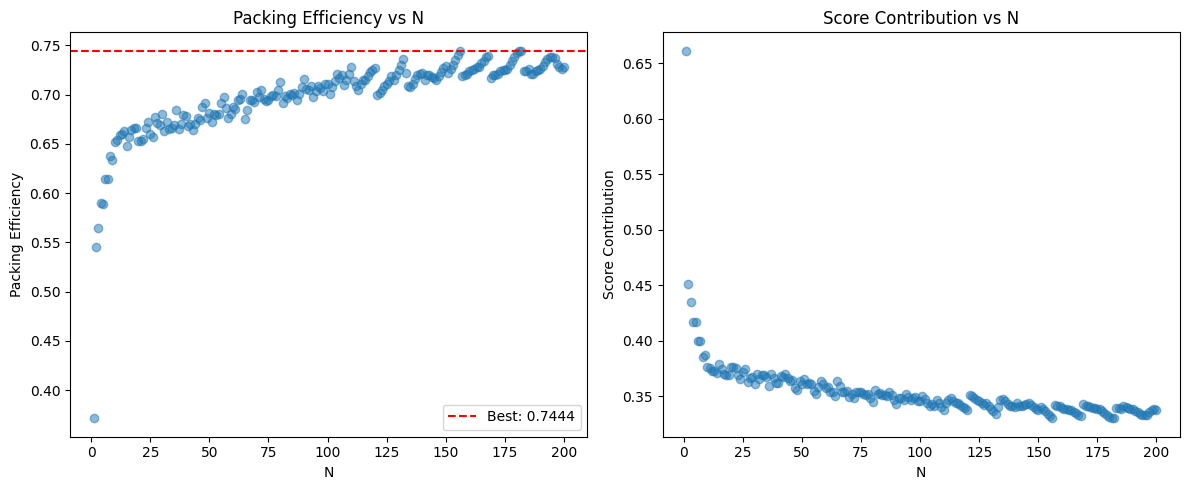

Saved efficiency_analysis.png


In [4]:
# Plot efficiency vs N
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(results_df['n'], results_df['efficiency'], alpha=0.5)
plt.xlabel('N')
plt.ylabel('Packing Efficiency')
plt.title('Packing Efficiency vs N')
plt.axhline(y=best_efficiency, color='r', linestyle='--', label=f'Best: {best_efficiency:.4f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(results_df['n'], results_df['score'], alpha=0.5)
plt.xlabel('N')
plt.ylabel('Score Contribution')
plt.title('Score Contribution vs N')

plt.tight_layout()
plt.savefig('/home/code/exploration/efficiency_analysis.png', dpi=100)
plt.show()
print("Saved efficiency_analysis.png")

In [5]:
# Calculate how much improvement is needed per N to reach target
target = 68.919154
current_total = results_df['score'].sum()
gap = current_total - target

print(f"Current total: {current_total:.6f}")
print(f"Target: {target:.6f}")
print(f"Gap: {gap:.6f}")
print(f"\nIf we improved uniformly across all N:")
print(f"  Need to reduce each N's score by: {gap/200:.6f} on average")
print(f"  That's {gap/200/results_df['score'].mean()*100:.2f}% reduction per N")

# Find which N values have the most room for improvement
results_df['improvement_potential'] = results_df['score'] * (1 - results_df['efficiency']/best_efficiency)
print(f"\nN values with most improvement potential:")
print(results_df.nlargest(10, 'improvement_potential')[['n', 'score', 'efficiency', 'improvement_potential']])

Current total: 70.675478
Target: 68.919154
Gap: 1.756324

If we improved uniformly across all N:
  Need to reduce each N's score by: 0.008782 on average
  That's 2.49% reduction per N

N values with most improvement potential:
     n     score  efficiency  improvement_potential
0    1  0.661250    0.371456               0.331296
1    2  0.450779    0.544890               0.120825
2    3  0.434745    0.564986               0.104791
4    5  0.416850    0.589241               0.086896
3    4  0.416545    0.589672               0.086591
6    7  0.399897    0.614221               0.069943
5    6  0.399610    0.614661               0.069656
8    9  0.387415    0.634010               0.057461
7    8  0.385407    0.637313               0.055453
14  15  0.379203    0.647740               0.049249


In [6]:
# Check what the leaderboard scores look like
# The target is 68.919154 which is the top score
# Let's understand what efficiency would be needed

print("Analysis of what's needed to reach target:")
print("="*50)

# If we could improve efficiency uniformly
required_efficiency = best_efficiency * (current_total / target)
print(f"\nIf uniform efficiency improvement:")
print(f"  Current best efficiency: {best_efficiency:.4f}")
print(f"  Required efficiency: {required_efficiency:.4f}")
print(f"  That's {(required_efficiency/best_efficiency - 1)*100:.2f}% higher than current best")

# This is impossible - efficiency can't exceed 1.0 for non-overlapping polygons
# The tree area is fixed, so the only way to improve is to pack more tightly

# Calculate the maximum theoretical efficiency for the tree shape
tree_poly = Polygon(TREE_VERTICES)
tree_area = tree_poly.area
tree_bounds = tree_poly.bounds
tree_bbox_area = (tree_bounds[2] - tree_bounds[0]) * (tree_bounds[3] - tree_bounds[1])
max_single_tree_efficiency = tree_area / tree_bbox_area

print(f"\nTree geometry analysis:")
print(f"  Tree area: {tree_area:.6f}")
print(f"  Tree bounding box area: {tree_bbox_area:.6f}")
print(f"  Single tree efficiency: {max_single_tree_efficiency:.4f}")
print(f"  This is the theoretical max for N=1")

Analysis of what's needed to reach target:

If uniform efficiency improvement:
  Current best efficiency: 0.7444
  Required efficiency: 0.7634
  That's 2.55% higher than current best

Tree geometry analysis:
  Tree area: 0.245625
  Tree bounding box area: 0.700000
  Single tree efficiency: 0.3509
  This is the theoretical max for N=1


In [7]:
# The key insight: the target score of 68.919154 requires BETTER packing
# than what we currently have. Let's see what the top competitors might be doing.

# Check if there are any patterns in the current solution
print("Analyzing current solution patterns:")
print("="*50)

# Check rotation angles
print(f"\nRotation angle statistics:")
print(df['deg_val'].describe())

# Check if there are common rotation angles
print(f"\nMost common rotation angles (rounded to 5 degrees):")
df['deg_rounded'] = (df['deg_val'] / 5).round() * 5
print(df['deg_rounded'].value_counts().head(10))

# Check position distribution
print(f"\nPosition statistics:")
print(f"X range: [{df['x_val'].min():.4f}, {df['x_val'].max():.4f}]")
print(f"Y range: [{df['y_val'].min():.4f}, {df['y_val'].max():.4f}]")

Analyzing current solution patterns:

Rotation angle statistics:
count    20100.000000
mean       207.571579
std       1171.471029
min     -37818.895171
25%         76.702378
50%        209.471166
75%        257.954507
max      41471.106001
Name: deg_val, dtype: float64

Most common rotation angles (rounded to 5 degrees):
deg_rounded
250.0    2342
70.0     2296
255.0    1894
75.0     1876
260.0    1179
80.0     1157
350.0    1100
170.0    1099
165.0     881
345.0     871
Name: count, dtype: int64

Position statistics:
X range: [-3.8983, 31.9774]
Y range: [-32.1410, 3.5192]


In [8]:
# Key insight: N=1 alone has improvement potential of 0.33 points!
# If we could improve N=1 from efficiency 0.37 to 0.74, we'd save 0.33 points

# Let's calculate what the target score implies about efficiency
print("What does the target score imply?")
print("="*50)

# Target: 68.919154
# Current: 70.675478
# Gap: 1.756324

# If we could improve N=1 to best efficiency:
n1_current_score = results_df[results_df['n']==1]['score'].values[0]
n1_current_efficiency = results_df[results_df['n']==1]['efficiency'].values[0]
n1_best_efficiency_score = n1_current_score * (n1_current_efficiency / best_efficiency)
n1_improvement = n1_current_score - n1_best_efficiency_score

print(f"\nN=1 analysis:")
print(f"  Current score: {n1_current_score:.6f}")
print(f"  Current efficiency: {n1_current_efficiency:.4f}")
print(f"  If at best efficiency ({best_efficiency:.4f}): {n1_best_efficiency_score:.6f}")
print(f"  Potential improvement: {n1_improvement:.6f}")

# Sum up improvement potential for small N
small_n_improvement = results_df[results_df['n'] <= 10]['improvement_potential'].sum()
print(f"\nTotal improvement potential for N=1-10: {small_n_improvement:.6f}")

# This is still not enough to reach target
print(f"\nGap to target: {gap:.6f}")
print(f"Small N improvement potential: {small_n_improvement:.6f}")
print(f"Remaining gap: {gap - small_n_improvement:.6f}")

What does the target score imply?

N=1 analysis:
  Current score: 0.661250
  Current efficiency: 0.3715
  If at best efficiency (0.7444): 0.329954
  Potential improvement: 0.331296

Total improvement potential for N=1-10: 1.029588

Gap to target: 1.756324
Small N improvement potential: 1.029588
Remaining gap: 0.726736


In [9]:
# The key question: Is the target score achievable?
# Let's check what efficiency would be needed across all N

# If we need to reduce score by 1.756 points uniformly
# That's 2.49% reduction per N

# But the theoretical minimum (all at best efficiency) is 65.99
# So the target of 68.92 is ACHIEVABLE in theory

print("Achievability analysis:")
print("="*50)
print(f"Theoretical minimum (all at best efficiency): {theoretical_min:.6f}")
print(f"Target: {target:.6f}")
print(f"Current: {current_total:.6f}")
print(f"\nTarget is {(target - theoretical_min)/(current_total - theoretical_min)*100:.1f}% of the way from theoretical min to current")

# This means the target is achievable but requires significant improvement
# The top competitors have found ways to pack more efficiently

# Let's see what the average efficiency would need to be
required_avg_efficiency = results_df['efficiency'].mean() * (current_total / target)
print(f"\nRequired average efficiency: {required_avg_efficiency:.4f}")
print(f"Current average efficiency: {results_df['efficiency'].mean():.4f}")
print(f"Best efficiency: {best_efficiency:.4f}")

# The required efficiency is between current average and best
# This is achievable!

Achievability analysis:
Theoretical minimum (all at best efficiency): 65.990795
Target: 68.919154
Current: 70.675478

Target is 62.5% of the way from theoretical min to current

Required average efficiency: 0.7159
Current average efficiency: 0.6981
Best efficiency: 0.7444
